# Introduction

This notebook shows how to create a neural networ to detect momo in images using Inception V3

# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt
import math

from shutil import copy2, rmtree
from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product


# Project modules below
from lib import util

In [2]:
# Load Inception V3.

InceptionV3        = keras.applications.inception_v3.InceptionV3
preprocess_input   = keras.applications.inception_v3.preprocess_input
image              = keras.preprocessing.image
Model              = keras.models.Model
Dense              = keras.layers.Dense
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
Callback           = keras.callbacks


In [3]:
inceptionV3Model = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')

# Uncomment to describe the inception v3 summary model
#print(inceptionV3Model.summary())

# Configuration 


In [4]:

# Change this value if you want to change the randomic data
SEED_APP = 9
SAVE_WEIGHTS = True
EPOCHS = 60
BATCH_SIZE = 10
IMG_W = IMG_H = 299
RESET_TRAINING_EXAMPLES = True


# Variables

In [5]:


tf.random.set_seed(SEED_APP)

MOMO_CLASSNAME    = "momo"
NO_MOMO_CLASSNAME = "no_momo"

MOUNT = "./"
DATASET_PATH = join(MOUNT, "dataset/")
RESULT_FOLDER_PATH = join(MOUNT,"result/")
RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH = RESULT_FOLDER_PATH + "inception_v3/"
DATESET_BASIC_PATH    = join(DATASET_PATH,'basic/')
DATESET_TRAINING_PATH = join(DATASET_PATH,'train/')
DATESET_TESTING_PATH  = join(DATASET_PATH,'test/')
DATESET_EVAL_PATH     = join(DATASET_PATH,'eval/')


DEFAULT_WEIGHTS_FILE_PATH = RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + 'weights.h5'

print(DATESET_BASIC_PATH)

./dataset/basic/


# Functions

In [6]:
def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path: str, model=inceptionV3Model) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):
    np.random.seed(SEED_APP)
    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getDatasetClasses():
    return getFolders(DATESET_BASIC_PATH)

def getOutputClasses():
    return [NO_MOMO_CLASSNAME,MOMO_CLASSNAME]
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        rmtree(filepath)
        
def resetFolderIfExist(path : str):
    deleteIfExist(path)
    createFolderIfNotExist(path)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        

def createConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]                
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def getDataForConfusionMatrix(useWeights:str =  DEFAULT_WEIGHTS_FILE_PATH ):
    
    momoModel.load_weights(useWeights)
    
    threshold = 0.1
    eval_Xs = []
    eval_Ys = []
    eval_preds = []
    files = []

    #folderPath = DATESET_TRAINING_PATH
    folderPath = DATESET_EVAL_PATH

    folders = getFolders(folderPath)

    for folder in folders:

        images                = getFolderFiles(folderPath+ folder)
        totalOfImagesInFolder = len(images)

        print("Processing" ,  folder , " total of images: ",totalOfImagesInFolder)

        for img in tqdm(images, file=stdout):
            src = folderPath + folder + "/" + img        
            files.append(src)
            result = predict(src,momoModel)[0][0]

            # generamos una lista con las probabilidades devueltas por el modelo para cada imagen.
            eval_preds.append(result)

            # generamos nuestra lista de y_true, es decir la etiqueta de quebería tener la foto.
            eval_Xs.append(1 if folder == MOMO_CLASSNAME else 0)

            # generamos nuestra lista de y_pred, es decir la etiqueta que nos dio la predicción.
            eval_Ys.append(1 if result > threshold else 0)

    files      = np.array(files)
    eval_preds = np.array(eval_preds)
    eval_Xs    = np.array(eval_Xs)
    eval_Ys    = np.array(eval_Ys)
    
    momoModel.load_weights(DEFAULT_WEIGHTS_FILE_PATH)
    return (files,eval_preds,eval_Xs,eval_Ys)
        

# Observe a single example

In [7]:
np.random.seed(SEED_APP)

CLASSES = getDatasetClasses()
RANDOM_POSITIVE_EXAMPLE_PATH = getRandomExample("momo")
RANDOM_POSITIVE_EXAMPLE_FILE = predict(RANDOM_POSITIVE_EXAMPLE_PATH)
print("Momo class random file path" , RANDOM_POSITIVE_EXAMPLE_FILE)

predict(RANDOM_POSITIVE_EXAMPLE_PATH)


Momo class random file path [[0.31326243 0.19618562 0.03071248 ... 0.29802546 0.24973837 0.29111505]]


array([[0.31326243, 0.19618562, 0.03071248, ..., 0.29802546, 0.24973837,
        0.29111505]], dtype=float32)

# Preparing InceptionV3 Model to fit it to our problem: identify momo in. images

In [8]:
# Take the output of the model
x = inceptionV3Model.output

# Add a full-conected layer of 1024 neurons with relu activation to our model output
x = Dense(1024, activation='relu')(x)
#x = Dense(512, activation='relu')(x)

# Add a output layer with only one neurone
momoOutput = Dense(1, activation='sigmoid')(x)

# Create the momo Model from our outputs
momoModel = Model(inputs=inceptionV3Model.input, outputs=momoOutput)

# Compile our model using adam and an optimizer for binari clasification
momoModel.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
#print(momoModel.summary())

# Pre training

## Prepare our test/training folders

In [10]:
# Read each class of the dataset
for ds_class in getOutputClasses():
    # Create the folders in the train/test folders
    resetFolderIfExist( DATESET_TRAINING_PATH  +  ds_class  )
    resetFolderIfExist( DATESET_TESTING_PATH   +  ds_class  )
    resetFolderIfExist( DATESET_EVAL_PATH      +  ds_class  )


## Fill the train/test/eval folders

In [11]:
def CreateTrainTestAndEvalFolders():
    np.random.seed(SEED_APP)
    DATASET_CLASSES = getDatasetClasses()

    # Proportions
    TRAINING_PERCENTAGE = 0.7
    TESTING_PERCENTAGE  = 0.15
    EVAL_PERCENTAGE     = 0.15

    ds_folders = getFolders(DATESET_BASIC_PATH)

    for ds_folder in ds_folders:

        path      = DATESET_BASIC_PATH + ds_folder
        files     = np.array(getFolderFiles(path))

        m         = len(files)

        trainIdx  = math.ceil( m * TRAINING_PERCENTAGE )
        testIdx   = math.ceil( m * TESTING_PERCENTAGE  ) 
        evalIdx   = math.ceil( m * EVAL_PERCENTAGE     )     

        np.random.shuffle(files)

        isPositiveClass      = ds_folder == MOMO_CLASSNAME
        folderTo             = MOMO_CLASSNAME if isPositiveClass else NO_MOMO_CLASSNAME

        trainingClassPath    = DATESET_TRAINING_PATH + folderTo
        testClassPath        = DATESET_TESTING_PATH  + folderTo
        evalClassPath        = DATESET_EVAL_PATH     + folderTo
        



        currentIndex     = 0
        trainingImages   = files[ currentIndex : currentIndex + trainIdx ]

        currentIndex     = currentIndex + trainIdx 
        testImages       = files[ currentIndex : currentIndex + testIdx  ]

        currentIndex     = currentIndex + testIdx
        evalImages       = files[ currentIndex :          ]

        print(
            "From folder '" + ds_folder  + "'"
            + " take " 
            + str(len(trainingImages)) + " Training examples, "
            + str(len(testImages))     + " Testing examples, and "
            + str(len(evalImages))     + " Eval examples."        
        )

        print("Copying traning files from " + path + " to " + trainingClassPath)
        for imageName in tqdm(trainingImages, file=stdout):
            copy2(path+ "/"+  imageName ,trainingClassPath + "/"+  imageName)

        print("Copying testing files from " + path + " to " + testClassPath)
        for imageName in tqdm(testImages, file=stdout):
            copy2(path+ "/"+  imageName ,testClassPath + "/"+  imageName)

        print("Copying eval files from "    + path + " to " + evalClassPath)
        for imageName in tqdm(evalImages, file=stdout):
            copy2(path+ "/"+  imageName ,evalClassPath + "/"+  imageName)
            
CreateTrainTestAndEvalFolders()


From folder 'meme' take 42 Training examples, 9 Testing examples, and 9 Eval examples.
Copying traning files from ./dataset/basic/meme to ./dataset/train/no_momo
100%|██████████| 42/42 [00:00<00:00, 709.42it/s]
Copying testing files from ./dataset/basic/meme to ./dataset/test/no_momo
100%|██████████| 9/9 [00:00<00:00, 890.93it/s]
Copying eval files from ./dataset/basic/meme to ./dataset/eval/no_momo
100%|██████████| 9/9 [00:00<00:00, 894.48it/s]
From folder 'person' take 62 Training examples, 14 Testing examples, and 12 Eval examples.
Copying traning files from ./dataset/basic/person to ./dataset/train/no_momo
100%|██████████| 62/62 [00:00<00:00, 750.07it/s]
Copying testing files from ./dataset/basic/person to ./dataset/test/no_momo
100%|██████████| 14/14 [00:00<00:00, 636.86it/s]
Copying eval files from ./dataset/basic/person to ./dataset/eval/no_momo
100%|██████████| 12/12 [00:00<00:00, 1281.94it/s]
From folder 'momo' take 80 Training examples, 17 Testing examples, and 16 Eval exampl


## Data augmentation

In [12]:
# Create a generator to pre process our dataset images
imageGenerator = ImageDataGenerator(
    rescale            = 1./255,       # Scale our data to our dataset scale
    horizontal_flip    = True,         # Horizontal mirror
    vertical_flip      = False,         # Disable vertical mirror
    rotation_range     = 7,
    width_shift_range  = 0.3,
    height_shift_range = 0.3,
    brightness_range   = (0.3, 0.7),
    shear_range        = 45.0,
    zoom_range         = [0.5, 1.5],
    fill_mode          = "reflect"
)

trainGenerator = imageGenerator.flow_from_directory(
        directory   = DATESET_TRAINING_PATH,
        target_size =  (IMG_H, IMG_W),
        batch_size  =  BATCH_SIZE,
        class_mode  =  'binary',
        classes     =  getOutputClasses())

testGenerator= imageGenerator.flow_from_directory(
        directory    = DATESET_TESTING_PATH,
        target_size  = (IMG_H, IMG_W),
        batch_size   = BATCH_SIZE,
        class_mode   = 'binary',
        classes      = getOutputClasses())

Found 184 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [13]:
trainGenerator.class_indices

{'no_momo': 0, 'momo': 1}

# Training

Lets save some util data from our foulders

In [14]:
trainPositiveFiles          = getFolderFiles(DATESET_TRAINING_PATH + MOMO_CLASSNAME)
trainNegativeFiles          = getFolderFiles(DATESET_TRAINING_PATH + NO_MOMO_CLASSNAME)
trainPositiveExamplesLength = len(trainPositiveFiles)
trainNegativeExamplesLength = len(trainNegativeFiles)
trainLength                 = trainPositiveExamplesLength + trainNegativeExamplesLength

print("Total train examples: ", trainLength , "positive: " , trainPositiveExamplesLength  , " negative: " , trainNegativeExamplesLength)

testPositiveFiles           = getFolderFiles(DATESET_TESTING_PATH + MOMO_CLASSNAME)
testNegativeFiles           = getFolderFiles(DATESET_TESTING_PATH + NO_MOMO_CLASSNAME)
testPositiveExamplesLength  = len(testPositiveFiles)
testNegativeExamplesLength  = len(testNegativeFiles)
testLength                  = testPositiveExamplesLength + testNegativeExamplesLength

print("Total test examples: ", testLength , "positive: " , testPositiveExamplesLength  , " negative: " , testNegativeExamplesLength)
print()

trainSteps = trainLength // BATCH_SIZE
testSteps  = testLength // BATCH_SIZE

print("Train Steps per epoch " , trainSteps)
print("Test Steps per epoch " , testSteps)

callbacks   = []

resetFolderIfExist(RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH)

if SAVE_WEIGHTS:
    weightsFileName  =  RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + 'weights-{epoch}.h5'
    mc = keras.callbacks.ModelCheckpoint(
        weightsFileName,
        save_weights_only=True,
         save_best_only=True
    )
    callbacks.append( mc )

Total train examples:  184 positive:  80  negative:  104
Total test examples:  40 positive:  17  negative:  23

Train Steps per epoch  18
Test Steps per epoch  4


In [15]:
progress = momoModel.fit_generator(
        trainGenerator,
        steps_per_epoch=trainSteps,
        epochs=EPOCHS,
        validation_data=testGenerator,
        validation_steps=testSteps,
        callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
18/18 [==============================] - 51s 3s/step - loss: 0.4664 - accuracy: 0.8046 - val_loss: 2819.0500 - val_accuracy: 0.5750
Epoch 2/60
18/18 [==============================] - 49s 3s/step - loss: 0.4311 - accuracy: 0.8678 - val_loss: 831531.1875 - val_accuracy: 0.4250
Epoch 3/60
18/18 [==============================] - 54s 3s/step - loss: 0.5204 - accuracy: 0.7989 - val_loss: 58311.4375 - val_accuracy: 0.4250
Epoch 4/60
18/18 [==============================] - 57s 3s/step - loss: 0.4729 - accuracy: 0.8506 - val_loss: 23.0719 - val_accuracy: 0.5500
Epoch 5/60
18/18 [==============================] - 55s 3s/step - loss: 0.6399 - accuracy: 0.7644 - val_loss: 3321.4036 - val_accuracy: 0.4250
Epoch 6/60
18/18 [==============================] - 56s 3s/step - loss: 0.5097 - accuracy: 0.7931 - val_loss: 2.2521 - val_accuracy: 0.6500
Epoch 7/60
18/18 [==============================] - 56s 3s/step - lo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


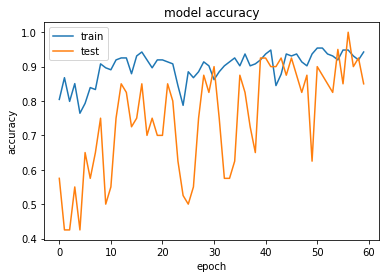

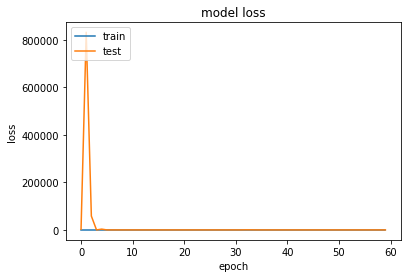

In [20]:
# listamos la información del entrenamiento
print(progress.history.keys())

momoModel.save_weights( DEFAULT_WEIGHTS_FILE_PATH)

# Acc stats
plt.plot(progress.history['accuracy'])
plt.plot(progress.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss stats
plt.plot(progress.history['loss'])
plt.plot(progress.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
momoModel.load_weights(DEFAULT_WEIGHTS_FILE_PATH)
progress = momoModel.fit_generator(
        trainGenerator,
        steps_per_epoch=trainSteps,
        epochs=EPOCHS,
        validation_data=testGenerator,
        validation_steps=testSteps,
        callbacks=callbacks
)

Epoch 1/60
18/18 [==============================] - 49s 3s/step - loss: 0.1471 - accuracy: 0.9598 - val_loss: 0.3472 - val_accuracy: 0.8750
Epoch 2/60
18/18 [==============================] - 62s 3s/step - loss: 0.1318 - accuracy: 0.9655 - val_loss: 0.4708 - val_accuracy: 0.8750
Epoch 3/60
18/18 [==============================] - 57s 3s/step - loss: 0.1302 - accuracy: 0.9655 - val_loss: 0.2833 - val_accuracy: 0.9250
Epoch 4/60
18/18 [==============================] - 58s 3s/step - loss: 0.1751 - accuracy: 0.9278 - val_loss: 0.9709 - val_accuracy: 0.7750
Epoch 5/60
18/18 [==============================] - 58s 3s/step - loss: 0.1775 - accuracy: 0.9500 - val_loss: 0.3857 - val_accuracy: 0.8500
Epoch 6/60
18/18 [==============================] - 56s 3s/step - loss: 0.1336 - accuracy: 0.9425 - val_loss: 0.2256 - val_accuracy: 0.9250
Epoch 7/60
18/18 [==============================] - 57s 3s/step - loss: 0.1589 - accuracy: 0.9368 - val_loss: 0.5514 - val_accuracy: 0.8250
Epoch 8/60
18/18 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


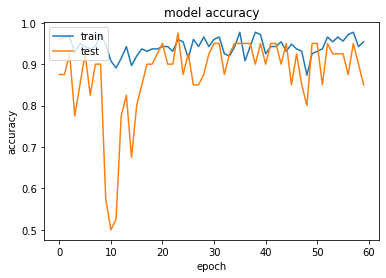

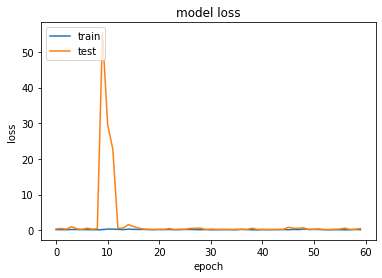

In [24]:
# listamos la información del entrenamiento
print(progress.history.keys())

momoModel.save_weights( DEFAULT_WEIGHTS_FILE_PATH)

# Acc stats
plt.plot(progress.history['accuracy'])
plt.plot(progress.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss stats
plt.plot(progress.history['loss'])
plt.plot(progress.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict Using the momo model

## Using the last weights

Processing no_momo  total of images:  21
100%|██████████| 21/21 [00:01<00:00, 12.56it/s]
Processing momo  total of images:  16
100%|██████████| 16/16 [00:01<00:00, 12.79it/s]


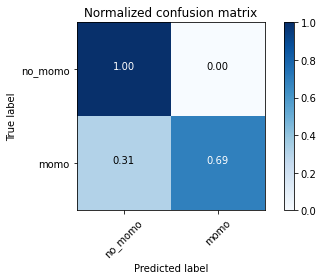

In [27]:
files,eval_preds,eval_Xs,eval_Ys = getDataForConfusionMatrix()
createConfusionMatrix(eval_Xs, eval_Ys, classes=getOutputClasses(), normalize=True)

In [28]:
momoModel.load_weights(DEFAULT_WEIGHTS_FILE_PATH)
progress = momoModel.fit_generator(
        trainGenerator,
        steps_per_epoch=trainSteps,
        epochs=EPOCHS,
        validation_data=testGenerator,
        validation_steps=testSteps
)

Epoch 1/60
18/18 [==============================] - 46s 3s/step - loss: 0.0877 - accuracy: 0.9655 - val_loss: 0.1783 - val_accuracy: 0.9750
Epoch 2/60
18/18 [==============================] - 50s 3s/step - loss: 0.0819 - accuracy: 0.9770 - val_loss: 0.0827 - val_accuracy: 0.9750
Epoch 3/60
18/18 [==============================] - 56s 3s/step - loss: 0.1203 - accuracy: 0.9598 - val_loss: 0.3739 - val_accuracy: 0.8500
Epoch 4/60
18/18 [==============================] - 54s 3s/step - loss: 0.0874 - accuracy: 0.9713 - val_loss: 0.1604 - val_accuracy: 0.9500
Epoch 5/60
18/18 [==============================] - 60s 3s/step - loss: 0.2707 - accuracy: 0.9080 - val_loss: 0.4133 - val_accuracy: 0.9000
Epoch 6/60
18/18 [==============================] - 55s 3s/step - loss: 0.1489 - accuracy: 0.9483 - val_loss: 0.0783 - val_accuracy: 0.9750
Epoch 7/60
18/18 [==============================] - 56s 3s/step - loss: 0.0905 - accuracy: 0.9655 - val_loss: 0.1022 - val_accuracy: 0.9500
Epoch 8/60
18/18 [==

Processing no_momo  total of images:  21
100%|██████████| 21/21 [00:01<00:00, 11.70it/s]
Processing momo  total of images:  16
100%|██████████| 16/16 [00:01<00:00, 12.07it/s]


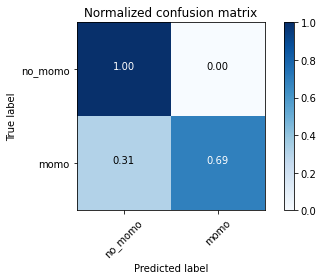

In [33]:
momoModel.save_weights( RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + "weights-v2.h5")
files,eval_preds,eval_Xs,eval_Ys = getDataForConfusionMatrix(RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + "weights-v2.h5")
createConfusionMatrix(eval_Xs, eval_Ys, classes=getOutputClasses(), normalize=True)

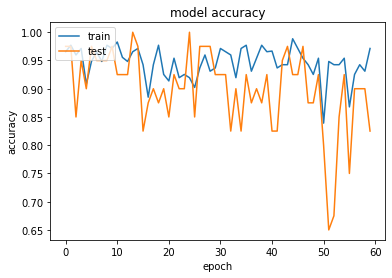

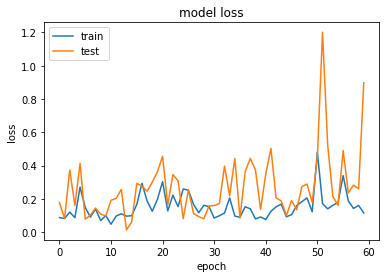

In [32]:

# Acc stats
plt.plot(progress.history['accuracy'])
plt.plot(progress.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss stats
plt.plot(progress.history['loss'])
plt.plot(progress.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()